In [516]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import seaborn as sn
import datetime
import random
from datetime import date
from pprint import pprint
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import statistics 
from statistics import mode

In [778]:
def aggregate_rows_by_driver_id(dataframe):
    '''
    Returns a new dataframe indexed by Driver ID using an optimal set of aggregations per column.
    This method will return a dataframe that only contains the columns listed below.
    Note: duplicate columns have already been pruned, so it is safe to pass in the full dataframe 
        and expect a pruned version in return. Also note that the `id_driver` will now be the index
        of the dataframe and NOT its own column.
    '''
    minimum = 'min'
    maximum = 'max'
    median = 'median'
    random_mode = lambda x: random.choice(pd.Series.mode(x if isinstance(x, list) else list(x)))

    aggregation = {
        'dt': maximum,
        'weekday': random_mode,
        'id_carrier_number': random_mode,
        'dim_carrier_type': random_mode,
        'dim_carrier_company_name': mode,
        'home_base_city': mode,
        'home_base_state': mode,
        'carrier_trucks': mode,
        'num_trucks': maximum,
        'interested_in_drayage': random_mode,
        'port_qualified': random_mode,
        'signup_source': random_mode,
        'ts_signup': maximum,
        'ts_first_approved': minimum,
        'days_signup_to_approval': maximum,
        'driver_with_twic': mode,
        'dim_preferred_lanes': mode,
        'first_load_date': minimum,
        'most_recent_load_date': maximum,
        'loads': random_mode,
        'marketplace_loads_otr': maximum,
        'marketplace_loads_atlas': maximum,
        'marketplace_loads': maximum,
        'brokerage_loads_otr': maximum,
        'brokerage_loads_atlas': maximum,
        'brokerage_loads': maximum,
        'total_loads': maximum
    }

    return dataframe.groupby(['id_driver']).agg(aggregation)

In [779]:
df = pd.read_csv('training_data_cleaned.csv')
df.shape

(83414, 33)

# Data Inspection

In [780]:
df

,Unnamed: 0,dt,weekday,year,id_driver,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,...,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads,date,recent_date
0,0,2021-01-20,3,2021,30222,U0117613,Owner Operator,Rosas Transport,Santa Fe Springs,CA,...,4,1,253,254,0,3,3,257,2021-01-20,2021-02-17
1,1,2020-03-09,1,2020,4524,C0090405,Fleet,Daylight Transport,Long Beach,CA,...,6,0,0,0,2671,0,2671,2671,2020-03-09,2021-02-15
2,2,2020-02-14,5,2020,31164,C0097099,Fleet,First Class Transport #8,Hawthorne,CA,...,1,29,82,111,30,19,49,160,2020-02-14,2020-12-18
3,3,2019-06-10,1,2019,8859,U0097935,Owner Operator,DTELLIS TRUCKING,Long Beach,CA,...,1,25,6,31,0,1,1,32,2019-06-10,2020-02-16
4,4,2019-12-03,2,2019,18870,U0106560,Owner Operator,Z&N Transport,Los Angeles,CA,...,4,1,233,234,0,9,9,243,2019-12-03,2020-02-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83409,83409,2020-11-09,1,2020,26609,C0095984,Fleet,WESTERN CONTAIN TRANSPORTATION LLC,Los Angeles,CA,...,3,2,895,897,0,93,93,990,2020-11-09,2021-02-16
83410,83410,2018-10-30,2,2018,595,C0090094,Fleet,MC Express Trucking LLC,Rosarito,B.C.,...,1,0,0,0,77,0,77,77,2018-10-30,2019-11-06
83411,83411,2020-07-14,2,2020,34520,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,...,2,0,0,0,0,0,0,101,2020-07-14,2021-02-17
83412,83412,2021-01-06,3,2021,34253,C0095226,Fleet,INTERMODAL DRAYAGE GROUP,San Bernardino,CA,...,1,8,2,10,0,0,0,10,2021-01-06,2021-01-16


In [781]:
aggregate_rows_by_driver_id(df)

,dt,weekday,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,...,first_load_date,most_recent_load_date,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads
id_driver,,,,,,,,,,,,,,,,,,,,,
20,2016-06-20,4,U0000035,Owner Operator,Mega Fleet Corp,Pasadena,CA,"[""dryvan""]",1.0,not specified,...,2015-10-23,2016-06-20,1,0,0,0,42,0,42,42
26,2015-10-29,4,U0000041,Owner Operator,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,...,2015-10-29,2015-10-29,1,0,0,0,1,0,1,1
27,2015-12-09,3,U0000042,Owner Operator,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,...,2015-10-18,2015-12-09,1,0,0,0,11,0,11,11
30,2018-12-05,3,U0000045,Owner Operator,A & J Transport,Riverside,CA,"[""reefer""]",1.0,not specified,...,2018-10-30,2018-12-05,1,0,0,0,4,0,4,4
31,2016-04-01,2,U0000046,Owner Operator,lv transportation llc,NaN,NaN,"[""dryvan""]",1.0,not specified,...,2016-02-28,2016-04-01,1,0,0,0,15,0,15,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37977,2021-02-11,4,C0098303,Fleet,"DOLPHIN TRANS, INC. DBA DOLPHIN EXPRESS",Norwalk,CA,"[""poweronly""]",1.0,yes,...,2021-02-11,2021-02-11,2,0,0,0,0,2,2,2
38039,2021-02-16,2,C0096844,Fleet,JT Transportation Inc,Los Angeles,CA,"[""dryvan""]",1.0,not specified,...,2021-02-16,2021-02-16,1,1,0,1,0,0,0,1
38060,2021-02-13,5,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,...,2021-02-12,2021-02-13,2,0,0,0,0,0,0,3


In [756]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83414 entries, 0 to 83413
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                83414 non-null  int64  
 1   dt                        83414 non-null  object 
 2   weekday                   83414 non-null  int64  
 3   year                      83414 non-null  int64  
 4   id_driver                 83414 non-null  int64  
 5   id_carrier_number         83414 non-null  object 
 6   dim_carrier_type          83414 non-null  object 
 7   dim_carrier_company_name  83367 non-null  object 
 8   home_base_city            83369 non-null  object 
 9   home_base_state           83369 non-null  object 
 10  carrier_trucks            83414 non-null  object 
 11  num_trucks                83344 non-null  float64
 12  interested_in_drayage     83414 non-null  object 
 13  port_qualified            83414 non-null  object 
 14  signup

In [757]:
df.describe()

,Unnamed: 0,weekday,year,id_driver,num_trucks,days_signup_to_approval,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads
count,83414.000000,83414.000000,83414.000000,83414.000000,83344.000000,71142.000000,83414.000000,83414.000000,83414.000000,83414.000000,83414.000000,83414.000000,83414.000000,83414.000000
mean,41706.500000,3.500060,2018.960870,18224.058060,22.579538,298.646201,2.075659,29.536241,71.511533,101.047774,148.027561,13.080166,161.107728,266.273371
std,24079.692014,1.687443,1.359275,11667.851627,48.816676,390.377138,2.669705,88.308416,194.548817,214.587614,415.376825,42.274194,413.197837,448.353468
min,0.000000,1.000000,2015.000000,20.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,20853.250000,2.000000,2018.000000,7890.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,37.000000
50%,41706.500000,3.000000,2019.000000,16299.000000,4.000000,61.000000,1.000000,2.000000,0.000000,13.000000,15.000000,0.000000,37.000000,110.000000
75%,62559.750000,5.000000,2020.000000,28974.000000,14.000000,497.000000,2.000000,23.000000,18.000000,94.000000,110.000000,1.000000,135.000000,325.000000
max,83413.000000,7.000000,2021.000000,38096.000000,195.000000,1653.000000,129.000000,902.000000,1324.000000,1348.000000,4266.000000,371.000000,4266.000000,4266.000000


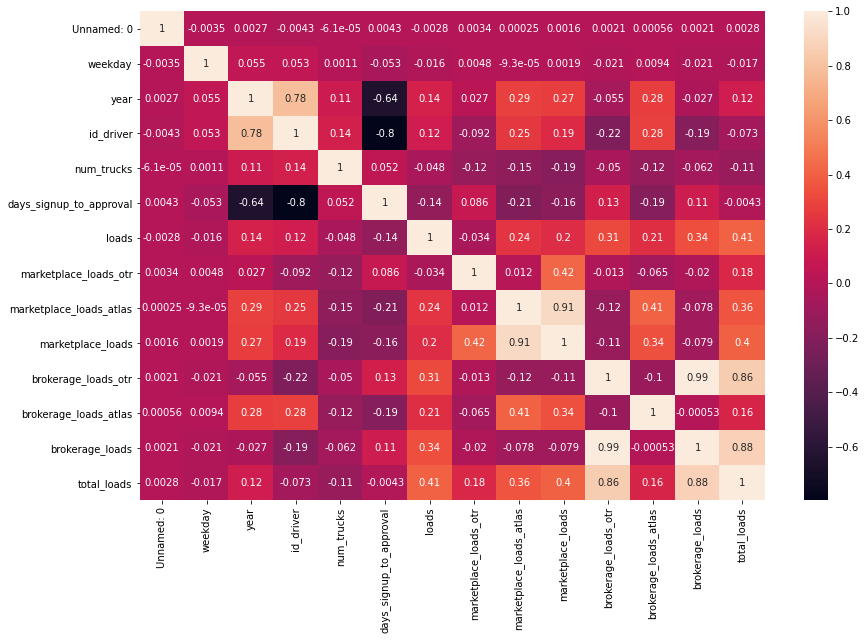

In [758]:
plt.figure(figsize=(14,9))
sn.heatmap(df.corr(), annot=True)
plt.show()

# Check for and Remove Duplicate Columns

In [759]:
df = pd.read_csv('training_data_cleaned.csv')
df.shape

(83414, 33)

In [760]:
for (columnName1, columnData1) in df.iteritems():
    for (columnName2, columnData2) in df.iteritems():
        if columnData1.equals(columnData2) and columnName1 is not columnName2:
            print(f'{columnName1} is equal to {columnName2}')

dt is equal to load_day
dt is equal to date
most_recent_load_date is equal to recent_date
load_day is equal to dt
load_day is equal to date
date is equal to dt
date is equal to load_day
recent_date is equal to most_recent_load_date


# Data Cleanup and Convenience

Drop `unnamed` since it is just a row count.

Drop the `year` column since it is redundant and already included in the `dt` column.

Drop the `date` and `load_day` columns since they are the same as the `dt` column.

Drop the `recent_date` since it is the same as the `most_recent_load_date` column.

Convert the `dt` and `most_recent_load_date` columns to `datetime.date` objects for convenience.

In [761]:
toRemove = ['Unnamed: 0', 'year', 'load_day', 'date', 'recent_date']
df.drop(columns=toRemove, inplace=True)
df.dt = [date.fromisoformat(d) for d in df.dt]
df.most_recent_load_date = [date.fromisoformat(d) for d in df.most_recent_load_date]

In [762]:
categoricals = df.columns[df.dtypes == object]
numericals = df.columns[df.dtypes != object]
n_drivers = df.id_driver.nunique()
driver_ids = sorted(df.id_driver.unique())

In [763]:
df.shape

(83414, 28)

# Augmentation Methodology
The following describes the methodology used to augment all of the driver information given that we are going to collapse the data into a frame with single rows per driver. Since we will be inherently losing information by collapsing all of the rows, we will need to supplement the dataset with new columns.

## Temporal Data
Most of the temporal information will be lost when we collapse the rows, so we will need additional columns that summarize that info:

- Start date (first load)
- End date (most recent load)
- Longevity (how long the driver has been employed, according to this dataset)
- Trip Frequency (standard deviation or some measure of variance between trips)
- Load Delta (some standard measure of how many days between each load)
- Preferred weekday (the mode of the `weekday` column
- Normal weekday (the mean or median of the `weekday` column
- Weekday distribution (are the weekdays consistent?)

## Location Data

- Roaming (does the driver have more than one reported `home_base_city` or `home_base_state`?
- Preferred Trip Distance (Use `interested_in_dryage` and `carrier_trucks` to determine a measure of how far the driver prefers to drive)

## Boolean Features

- Multiple signup dates (did this person apply to become a driver more than once?)

`id_driver`: Used as an index. All of the information will be rolled up into a single row for each driver.

In [10]:
drivers = pd.DataFrame()
drivers['id_driver'] = driver_ids
drivers.set_index('id_driver', inplace=True)

In [11]:
drivers.head()

""
id_driver
20
26
27
30
31


---

`dt`: three columns: earliest, latest, and longevity

In [12]:
drivers['dt_earliest'] = df.groupby('id_driver').dt.min()
drivers['dt_latest'] = df.groupby('id_driver').dt.max()
drivers['longevity'] = [t.days + 1 for t in drivers.dt_latest - drivers.dt_earliest]

In [13]:
drivers.head()

,dt_earliest,dt_latest,longevity
id_driver,,,
20,2015-10-23,2016-06-20,242
26,2015-10-29,2015-10-29,1
27,2015-10-18,2015-12-09,53
30,2018-10-30,2018-12-05,37
31,2016-02-28,2016-04-01,34


---

`weekday (mon, wed, etc)`: most frequent weekday

In [14]:
drivers['weekday'] = df.groupby('id_driver').weekday.agg(pd.Series.mode)

In [15]:
drivers.head()

,dt_earliest,dt_latest,longevity,weekday
id_driver,,,,
20,2015-10-23,2016-06-20,242,4
26,2015-10-29,2015-10-29,1,4
27,2015-10-18,2015-12-09,53,3
30,2018-10-30,2018-12-05,37,3
31,2016-02-28,2016-04-01,34,2


---

`dim_carrier_type`: Redundant, already included in `id_carrier_number`, which starts with a `U` if `Onwer Operator` and a `C` if `Fleet`

`id_carrier_number`: Encode a new boolean column (called `owner_operator`) that is 0 if `Fleet` or 1 if `Owner Operator`

In [16]:
self_owned = sorted(df.id_driver[df.id_carrier_number.str.slice(start=0, stop=1) == 'U'].unique())

In [17]:
drivers['self_owned'] = False
drivers['self_owned'] = label_encoder.fit_transform(drivers.index.isin(self_owned))

In [18]:
drivers.self_owned.value_counts()

0    4083
1    1205
Name: self_owned, dtype: int64

---



In [19]:
drivers['carrier_trucks'] = df.groupby('id_driver').carrier_trucks.agg(pd.Series.mode)
drivers

,dt_earliest,dt_latest,longevity,weekday,self_owned,carrier_trucks
id_driver,,,,,,
20,2015-10-23,2016-06-20,242,4,1,"[""dryvan""]"
26,2015-10-29,2015-10-29,1,4,1,"[""dryvan""]"
27,2015-10-18,2015-12-09,53,3,1,"[""dryvan""]"
30,2018-10-30,2018-12-05,37,3,1,"[""reefer""]"
31,2016-02-28,2016-04-01,34,2,1,"[""dryvan""]"
...,...,...,...,...,...,...
37977,2021-02-11,2021-02-11,1,4,0,"[""poweronly""]"
38039,2021-02-16,2021-02-16,1,2,0,"[""dryvan""]"
38060,2021-02-12,2021-02-13,2,"[5, 6]",0,"[""poweronly"", ""dryvan""]"


---



In [20]:
drivers['driver_home_base_state'] = df.groupby('id_driver').home_base_state.agg(pd.Series.mode)
drivers

,dt_earliest,dt_latest,longevity,weekday,self_owned,carrier_trucks,driver_home_base_state
id_driver,,,,,,,
20,2015-10-23,2016-06-20,242,4,1,"[""dryvan""]",CA
26,2015-10-29,2015-10-29,1,4,1,"[""dryvan""]",CA
27,2015-10-18,2015-12-09,53,3,1,"[""dryvan""]",CA
30,2018-10-30,2018-12-05,37,3,1,"[""reefer""]",CA
31,2016-02-28,2016-04-01,34,2,1,"[""dryvan""]",[]
...,...,...,...,...,...,...,...
37977,2021-02-11,2021-02-11,1,4,0,"[""poweronly""]",CA
38039,2021-02-16,2021-02-16,1,2,0,"[""dryvan""]",CA
38060,2021-02-12,2021-02-13,2,"[5, 6]",0,"[""poweronly"", ""dryvan""]",CA


In [21]:
driver_port_qualified = df.groupby('id_driver').port_qualified.agg(pd.Series.mode)
label_encoder.fit(['no', 'yes'])
drivers['port_qualified'] = label_encoder.transform(driver_port_qualified)
drivers

,dt_earliest,dt_latest,longevity,weekday,self_owned,carrier_trucks,driver_home_base_state,port_qualified
id_driver,,,,,,,,
20,2015-10-23,2016-06-20,242,4,1,"[""dryvan""]",CA,0
26,2015-10-29,2015-10-29,1,4,1,"[""dryvan""]",CA,0
27,2015-10-18,2015-12-09,53,3,1,"[""dryvan""]",CA,0
30,2018-10-30,2018-12-05,37,3,1,"[""reefer""]",CA,0
31,2016-02-28,2016-04-01,34,2,1,"[""dryvan""]",[],0
...,...,...,...,...,...,...,...,...
37977,2021-02-11,2021-02-11,1,4,0,"[""poweronly""]",CA,1
38039,2021-02-16,2021-02-16,1,2,0,"[""dryvan""]",CA,0
38060,2021-02-12,2021-02-13,2,"[5, 6]",0,"[""poweronly"", ""dryvan""]",CA,1


---

In [22]:
interested_in_drayage = df.groupby('id_driver').interested_in_drayage.agg(pd.Series.mode)
interested_in_dryage = interested_in_drayage == 'yes'
drivers['interested_in_dryage'] = label_encoder.fit_transform(interested_in_dryage)
drivers

,dt_earliest,dt_latest,longevity,weekday,self_owned,carrier_trucks,driver_home_base_state,port_qualified,interested_in_dryage
id_driver,,,,,,,,,
20,2015-10-23,2016-06-20,242,4,1,"[""dryvan""]",CA,0,0
26,2015-10-29,2015-10-29,1,4,1,"[""dryvan""]",CA,0,0
27,2015-10-18,2015-12-09,53,3,1,"[""dryvan""]",CA,0,0
30,2018-10-30,2018-12-05,37,3,1,"[""reefer""]",CA,0,0
31,2016-02-28,2016-04-01,34,2,1,"[""dryvan""]",[],0,0
...,...,...,...,...,...,...,...,...,...
37977,2021-02-11,2021-02-11,1,4,0,"[""poweronly""]",CA,1,1
38039,2021-02-16,2021-02-16,1,2,0,"[""dryvan""]",CA,0,0
38060,2021-02-12,2021-02-13,2,"[5, 6]",0,"[""poweronly"", ""dryvan""]",CA,1,1


In [23]:
pd.get_dummies(df.signup_source)

,Mobile,Other
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
83409,0,1
83410,0,1
83411,0,1
83412,0,1


# Get the latest trip for each unique ID

In order to collapse the data properly, we need to use various aggregation methods, depending on the column. Here we list out each column explicitly and determine the best aggregation method for each.

In [753]:
# Convenience method for printing the dictionary contents
print(f'{len(df.columns)} columns:')
for col in df.columns:
    print(f"'{col}': methodhere,")

28 columns:
'dt': methodhere,
'weekday': methodhere,
'id_driver': methodhere,
'id_carrier_number': methodhere,
'dim_carrier_type': methodhere,
'dim_carrier_company_name': methodhere,
'home_base_city': methodhere,
'home_base_state': methodhere,
'carrier_trucks': methodhere,
'num_trucks': methodhere,
'interested_in_drayage': methodhere,
'port_qualified': methodhere,
'signup_source': methodhere,
'ts_signup': methodhere,
'ts_first_approved': methodhere,
'days_signup_to_approval': methodhere,
'driver_with_twic': methodhere,
'dim_preferred_lanes': methodhere,
'first_load_date': methodhere,
'most_recent_load_date': methodhere,
'loads': methodhere,
'marketplace_loads_otr': methodhere,
'marketplace_loads_atlas': methodhere,
'marketplace_loads': methodhere,
'brokerage_loads_otr': methodhere,
'brokerage_loads_atlas': methodhere,
'brokerage_loads': methodhere,
'total_loads': methodhere,


In [749]:
# Aggregation methods
minimum = 'min'
maximum = 'max'
median = 'median'
random_mode = lambda x: random.choice(pd.Series.mode(x if isinstance(x, list) else list(x)))

aggregation = {
    'dt': maximum,
    'weekday': random_mode,
    'id_carrier_number': random_mode,
    'dim_carrier_type': random_mode,
    'dim_carrier_company_name': mode,
    'home_base_city': mode,
    'home_base_state': mode,
    'carrier_trucks': mode,
    'num_trucks': maximum,
    'interested_in_drayage': random_mode,
    'port_qualified': random_mode,
    'signup_source': random_mode,
    'ts_signup': maximum,
    'ts_first_approved': minimum,
    'days_signup_to_approval': maximum,
    'driver_with_twic': mode,
    'dim_preferred_lanes': mode,
    'first_load_date': minimum,
    'most_recent_load_date': maximum,
    'loads': random_mode,
    'marketplace_loads_otr': maximum,
    'marketplace_loads_atlas': maximum,
    'marketplace_loads': maximum,
    'brokerage_loads_otr': maximum,
    'brokerage_loads_atlas': maximum,
    'brokerage_loads': maximum,
    'total_loads': maximum
}

driver_most_recent = df.groupby(['id_driver']).agg(aggregation)

In [750]:
driver_most_recent

,dt,weekday,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,...,first_load_date,most_recent_load_date,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads
id_driver,,,,,,,,,,,,,,,,,,,,,
20,2016-06-20,4,U0000035,Owner Operator,Mega Fleet Corp,Pasadena,CA,"[""dryvan""]",1.0,not specified,...,2015-10-23,2016-06-20,1,0,0,0,42,0,42,42
26,2015-10-29,4,U0000041,Owner Operator,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,...,2015-10-29,2015-10-29,1,0,0,0,1,0,1,1
27,2015-12-09,3,U0000042,Owner Operator,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,...,2015-10-18,2015-12-09,1,0,0,0,11,0,11,11
30,2018-12-05,3,U0000045,Owner Operator,A & J Transport,Riverside,CA,"[""reefer""]",1.0,not specified,...,2018-10-30,2018-12-05,1,0,0,0,4,0,4,4
31,2016-04-01,2,U0000046,Owner Operator,lv transportation llc,NaN,NaN,"[""dryvan""]",1.0,not specified,...,2016-02-28,2016-04-01,1,0,0,0,15,0,15,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37977,2021-02-11,4,C0098303,Fleet,"DOLPHIN TRANS, INC. DBA DOLPHIN EXPRESS",Norwalk,CA,"[""poweronly""]",1.0,yes,...,2021-02-11,2021-02-11,2,0,0,0,0,2,2,2
38039,2021-02-16,2,C0096844,Fleet,JT Transportation Inc,Los Angeles,CA,"[""dryvan""]",1.0,not specified,...,2021-02-16,2021-02-16,1,1,0,1,0,0,0,1
38060,2021-02-13,5,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,...,2021-02-12,2021-02-13,2,0,0,0,0,0,0,3


In [85]:
approved = driver_most_recent[driver_most_recent.days_signup_to_approval.isnull() == False]

In [86]:
approved.days_signup_to_approval

id_driver
30       1136.0
41       1141.0
50       1193.0
64       1275.0
184      1261.0
          ...  
37977      35.0
38039      20.0
38060       0.0
38065       0.0
38096      18.0
Name: days_signup_to_approval, Length: 3963, dtype: float64

## Add boolean column for "self owned" or not

In [26]:
driver_most_recent['self_owned'] = False
driver_most_recent['self_owned'] = label_encoder.fit_transform(driver_most_recent.index.isin(self_owned))

In [27]:
driver_most_recent

,dt,weekday,id_carrier_number,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,port_qualified,...,load_day,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads,self_owned
id_driver,,,,,,,,,,,,,,,,,,,,,
20,2016-06-20,7,U0000035,Mega Fleet Corp,Pasadena,CA,"[""dryvan""]",1.0,not specified,no,...,2016-06-20,4,0,0,0,42,0,42,42,1
26,2015-10-29,4,U0000041,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,no,...,2015-10-29,1,0,0,0,1,0,1,1,1
27,2015-12-09,7,U0000042,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,no,...,2015-12-09,2,0,0,0,11,0,11,11,1
30,2018-12-05,3,U0000045,A & J Transport,Riverside,CA,"[""reefer""]",1.0,not specified,no,...,2018-12-05,1,0,0,0,4,0,4,4,1
31,2016-04-01,7,U0000046,lv transportation llc,NaN,NaN,"[""dryvan""]",1.0,not specified,no,...,2016-04-01,4,0,0,0,15,0,15,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37977,2021-02-11,4,C0098303,"DOLPHIN TRANS, INC. DBA DOLPHIN EXPRESS",Norwalk,CA,"[""poweronly""]",1.0,yes,yes,...,2021-02-11,2,0,0,0,0,2,2,2,0
38039,2021-02-16,2,C0096844,JT Transportation Inc,Los Angeles,CA,"[""dryvan""]",1.0,not specified,no,...,2021-02-16,1,1,0,1,0,0,0,1,0
38060,2021-02-13,6,C0094651,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,...,2021-02-13,2,0,0,0,0,0,0,3,0


## Add columns for mean, median, and standard deviation of dates

In [28]:
df['Date_int'] = pd.to_datetime(df['dt']).astype(int)
res = df.groupby('id_driver').agg(['mean', 'median', 'std'])
res.columns = ['_'.join(c) for c in res.columns.values]

res['Date_mean'] = pd.to_datetime(res['Date_int_mean'])
res['Date_median'] = pd.to_datetime(res['Date_int_median'])
res['Date_std'] = pd.to_timedelta(res['Date_int_std'])
res = res[['Date_mean', 'Date_median', 'Date_std']]

driver_most_recent['dt_mean'] = res['Date_mean']
driver_most_recent['dt_median'] = res['Date_median']
driver_most_recent['dt_std'] = res['Date_std']
# driver_most_recent.drop(columns=['Date_int'], inplace=True)

In [29]:
driver_most_recent.head()

,dt,weekday,id_carrier_number,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,port_qualified,...,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads,self_owned,dt_mean,dt_median,dt_std
id_driver,,,,,,,,,,,,,,,,,,,,,
20,2016-06-20,7,U0000035,Mega Fleet Corp,Pasadena,CA,"[""dryvan""]",1.0,not specified,no,...,0,0,42,0,42,42,1,2016-01-13 09:46:40.000000000,2015-12-29 00:00:00,60 days 03:42:24.874807908
26,2015-10-29,4,U0000041,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,no,...,0,0,1,0,1,1,1,2015-10-29 00:00:00.000000000,2015-10-29 00:00:00,NaT
27,2015-12-09,7,U0000042,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,no,...,0,0,11,0,11,11,1,2015-11-15 16:00:00.000000000,2015-11-23 00:00:00,18 days 16:21:25.202212076
30,2018-12-05,3,U0000045,A & J Transport,Riverside,CA,"[""reefer""]",1.0,not specified,no,...,0,0,4,0,4,4,1,2018-11-16 18:00:00.000000000,2018-11-16 12:00:00,19 days 22:32:52.091717299
31,2016-04-01,7,U0000046,lv transportation llc,NaN,NaN,"[""dryvan""]",1.0,not specified,no,...,0,0,15,0,15,15,1,2016-03-17 10:54:32.727272704,2016-03-15 00:00:00,12 days 00:16:21.353745482


## Add columns for mean, median, and standard deviation of weekday

In [68]:
driver_most_recent['weekday_mean'] = round(df.groupby('id_driver').weekday.agg(['mean'])).astype(int)
driver_most_recent['weekday_median'] = round(df.groupby('id_driver').weekday.agg(['median'])).astype(int)
driver_most_recent['weekday_std'] = round(df.groupby('id_driver').weekday.agg(['std']))
driver_most_recent.drop(columns=['weekday'], inplace=True)

In [196]:
driver_most_recent

,dt,weekday,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,...,dim_preferred_lanes,first_load_date,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads
id_driver,,,,,,,,,,,,,,,,,,,,,
20,2016-06-20,7,U0000035,Owner Operator,Mega Fleet Corp,Pasadena,CA,"[""dryvan""]",1.0,not specified,...,NaN,2015-10-23,4,0,0,0,42,0,42,42
26,2015-10-29,4,U0000041,Owner Operator,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,...,NaN,2015-10-29,1,0,0,0,1,0,1,1
27,2015-12-09,7,U0000042,Owner Operator,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,...,NaN,2015-10-18,2,0,0,0,11,0,11,11
30,2018-12-05,3,U0000045,Owner Operator,A & J Transport,Riverside,CA,"[""reefer""]",1.0,not specified,...,NaN,2018-10-30,1,0,0,0,4,0,4,4
31,2016-04-01,7,U0000046,Owner Operator,lv transportation llc,NaN,NaN,"[""dryvan""]",1.0,not specified,...,NaN,2016-02-28,4,0,0,0,15,0,15,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37977,2021-02-11,4,C0098303,Fleet,"DOLPHIN TRANS, INC. DBA DOLPHIN EXPRESS",Norwalk,CA,"[""poweronly""]",1.0,yes,...,NaN,2021-02-11,2,0,0,0,0,2,2,2
38039,2021-02-16,2,C0096844,Fleet,JT Transportation Inc,Los Angeles,CA,"[""dryvan""]",1.0,not specified,...,NaN,2021-02-16,1,1,0,1,0,0,0,1
38060,2021-02-13,6,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,...,NaN,2021-02-12,2,0,0,0,0,0,0,3


In [74]:
driver_most_recent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5288 entries, 20 to 38096
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   dt                        5288 non-null   object         
 1   id_carrier_number         5288 non-null   object         
 2   dim_carrier_company_name  5281 non-null   object         
 3   home_base_city            5276 non-null   object         
 4   home_base_state           5276 non-null   object         
 5   carrier_trucks            5288 non-null   object         
 6   num_trucks                5246 non-null   float64        
 7   interested_in_drayage     5288 non-null   object         
 8   port_qualified            5288 non-null   object         
 9   signup_source             5288 non-null   object         
 10  ts_signup                 5288 non-null   object         
 11  ts_first_approved         3963 non-null   object         
 12  days

# Part 1 - Generate Labels

Where drivers in the 75th percentile of `total_loads` and the 75th percentile of `most_recent_load_date` are assigned a label of 1 (indicating a high performing driver) with all others being assigned a 0 - (NOTE: your labels will likely be unbalanced. You will need to determine an approach to balancing your labels).

## Total Loads

### Option 1 - `total_loads` from the entire dataset

<AxesSubplot:>

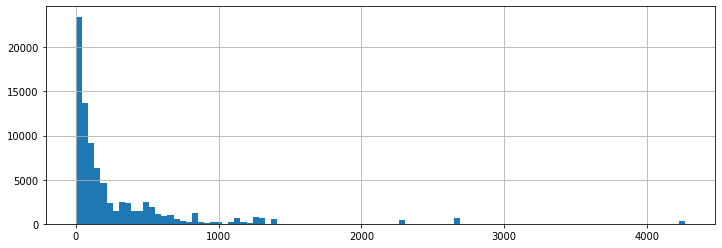

In [264]:
plt.figure(figsize=(12,4))
df.total_loads.hist(bins=100)

In [265]:
top_loads = df.total_loads.quantile(0.75)
print(f'The top 75th percentile of loads is >= {top_loads}')

The top 75th percentile of loads is >= 325.0


### Option 2 - `total_loads` from the collapsed dataset

<AxesSubplot:>

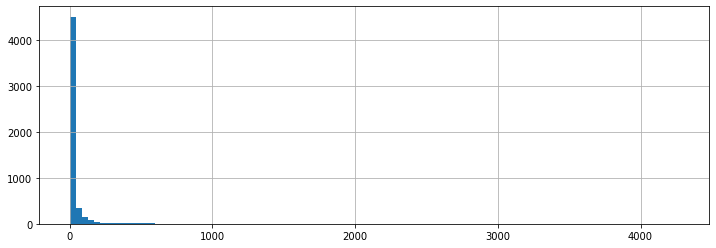

In [266]:
plt.figure(figsize=(12,4))
driver_most_recent.total_loads.hist(bins=100)

In [267]:
top_loads = driver_most_recent.total_loads.quantile(0.75)
print(f'The top 75th percentile of loads is >= {top_loads}')

The top 75th percentile of loads is >= 17.0


## Most Recent Load Date

### Option 1 - `most_recent_load_date` from the full dataset

<AxesSubplot:>

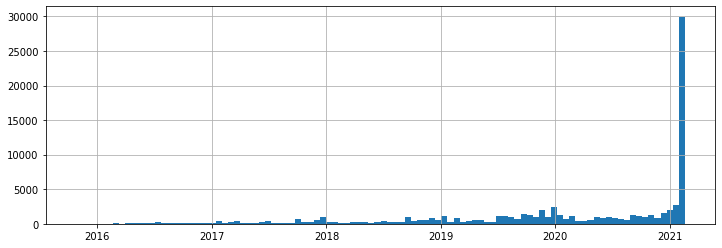

In [268]:
plt.figure(figsize=(12,4))
df.most_recent_load_date.hist(bins=100)

In [272]:
top_most_recent = df.most_recent_load_date.quantile(0.75)
print(f'The top 75th percentile of most_recent_load_date falls on {top_most_recent}')

The top 75th percentile of most_recent_load_date falls on 2021-02-14 00:00:00


### Option 2 - `most_recent_load_date` from the collapsed dataset

<AxesSubplot:>

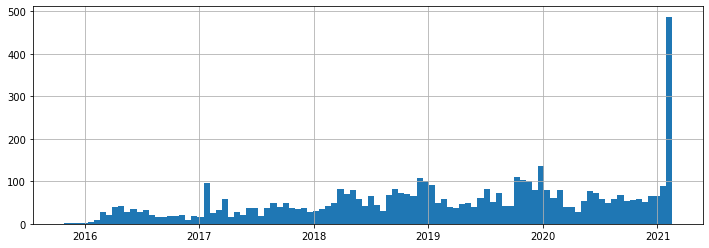

In [270]:
plt.figure(figsize=(12,4))
driver_most_recent.most_recent_load_date.hist(bins=100)

In [271]:
top_most_recent = driver_most_recent.most_recent_load_date.quantile(0.75)
print(f'The top 75th percentile of most_recent_load_date falls on {top_most_recent}')

The top 75th percentile of most_recent_load_date falls on 2020-05-19 00:00:00


## Combinations of the above options

### Option 1&1 (requires collapsing again)

In [332]:
top_loads = df.total_loads.quantile(0.75)
top_most_recent = df.most_recent_load_date.quantile(0.75)
top = df[(df.total_loads >= top_loads) & (df.most_recent_load_date >= top_most_recent)]
top = top.groupby('id_driver').agg('max')
top

,dt,weekday,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,...,first_load_date,most_recent_load_date,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads
id_driver,,,,,,,,,,,,,,,,,,,,,
3851,2021-02-17,7,U0093691,Owner Operator,pappy's trucking,Los Angeles,CA,"[""dryvan""]",1.0,not specified,...,2017-06-27,2021-02-17,4,286,4,290,226,0,226,516
4516,2021-02-16,7,C0090399,Fleet,ABF FREIGHT,Fort Smith,AR,"[""dryvan""]",2.0,not specified,...,2018-07-31,2021-02-16,28,0,0,0,1255,0,1255,1255
4524,2021-02-15,7,C0090405,Fleet,Daylight Transport,Long Beach,CA,"[""dryvan""]",6.0,not specified,...,2017-01-20,2021-02-15,22,0,0,0,2671,0,2671,2671
7879,2021-02-14,7,C0090913,Fleet,the custom companies inc,Northlake,IL,"[""dryvan""]",2.0,yes,...,2016-06-02,2021-02-14,7,0,0,0,346,0,346,346
13215,2021-02-16,7,U0101600,Owner Operator,West East Men Transportation Inc,Long Beach,CA,"[""poweronly""]",1.0,yes,...,2020-01-27,2021-02-16,9,0,423,423,0,11,11,434
14657,2021-02-16,7,C0093129,Fleet,USA Global,La Mirada,CA,"[""dryvan""]",1.0,yes,...,2018-10-02,2021-02-16,16,1,0,1,517,0,517,518
15913,2021-02-16,7,C0091573,Fleet,Global Express Trucking Corp.,San Diego,CA,"[""dryvan"", ""poweronly""]",5.0,not specified,...,2018-11-07,2021-02-16,4,2,0,2,419,0,419,421
16075,2021-02-15,7,C0093546,Fleet,SARINANA TRUCKING,Santa Ana,CA,"[""poweronly""]",1.0,not specified,...,2018-11-15,2021-02-15,22,0,0,0,669,0,669,669
16280,2021-02-14,7,U0104254,Owner Operator,JC&A Transportation Inc,Los Angeles,CA,"[""poweronly""]",1.0,yes,...,2020-08-31,2021-02-14,14,0,417,417,0,247,247,664


### Option 1&2 (requires collapsing again)

In [333]:
top_loads = df.total_loads.quantile(0.75)
top_most_recent = driver_most_recent.most_recent_load_date.quantile(0.75)
top = df[(df.total_loads >= top_loads) & (driver_most_recent.most_recent_load_date >= top_most_recent)]
top = top.groupby('id_driver').agg('max')
top

,dt,weekday,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,...,first_load_date,most_recent_load_date,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads
id_driver,,,,,,,,,,,,,,,,,,,,,
33,2017-11-03,5,U0000048,Owner Operator,iDC Logistics,Sierra Madre,CA,"[""dryvan""]",1.0,not specified,...,2015-10-14,2017-12-14,5,0,0,0,669,0,669,669
38,2017-07-17,4,U0000054,Owner Operator,iDC Logistics,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,...,2015-10-19,2017-12-14,5,0,0,0,656,0,656,656
41,2019-08-23,5,U0000058,Owner Operator,SHALISA & VP TRUCKING LLC,Hawthorne,CA,"[""poweronly""]",1.0,not specified,...,2015-10-21,2019-11-08,2,46,6,52,425,0,425,477
154,2017-10-08,7,U0090195,Owner Operator,IDC,"Sierra Madre,",CA,"[""dryvan""]",1.0,yes,...,2015-10-04,2017-12-14,7,1,0,1,1292,0,1292,1293
329,2017-03-17,6,C0090004,Fleet,IDC OTR,City of industry,CA,"[""dryvan"", ""reefer""]",17.0,not specified,...,2016-02-02,2019-01-03,1,21,0,21,338,0,338,359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35581,2021-02-12,5,U0122053,Owner Operator,Eagle star logistics inc,Moreno Valley,CA,"[""poweronly""]",1.0,yes,...,2020-10-16,2021-02-17,9,0,369,369,0,44,44,413
36275,2021-01-23,6,U0122637,Owner Operator,JJK Trucking Inc,Rosemead,CA,"[""poweronly""]",1.0,yes,...,2020-10-04,2021-02-17,7,0,387,387,0,145,145,532
36637,2020-11-13,5,C0098403,Fleet,SDLM,Long Beach,CA,"[""poweronly""]",2.0,yes,...,2020-10-31,2021-02-17,4,0,331,331,0,12,12,343


### Option 2&1 (requires collapsing again)

In [334]:
top_loads = driver_most_recent.total_loads.quantile(0.75)
top_most_recent = df.most_recent_load_date.quantile(0.75)
top = df[(driver_most_recent.total_loads >= top_loads) & (df.most_recent_load_date >= top_most_recent)]
top = top.groupby('id_driver').agg('max')
top

,dt,weekday,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,...,first_load_date,most_recent_load_date,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads
id_driver,,,,,,,,,,,,,,,,,,,,,
3721,2020-09-09,3,U0093573,Owner Operator,Amit carrier inc,La Habra,CA,"[""dryvan""]",1.0,not specified,...,2019-05-14,2021-02-16,1,9,61,70,0,2,2,72
3851,2020-01-13,5,U0093691,Owner Operator,pappy's trucking,Los Angeles,CA,"[""dryvan""]",1.0,not specified,...,2017-06-27,2021-02-17,1,286,4,290,226,0,226,516
4516,2020-12-02,4,C0090399,Fleet,ABF FREIGHT,Fort Smith,AR,"[""dryvan""]",2.0,not specified,...,2018-07-31,2021-02-16,10,0,0,0,1255,0,1255,1255
4524,2021-02-03,5,C0090405,Fleet,Daylight Transport,Long Beach,CA,"[""dryvan""]",6.0,not specified,...,2017-01-20,2021-02-15,7,0,0,0,2671,0,2671,2671
6223,2020-10-01,4,U0095596,Owner Operator,XA Torres Delivery LLC,Perris,CA,"[""dryvan""]",1.0,not specified,...,2017-05-02,2021-02-17,1,12,0,12,155,0,155,167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37534,2021-02-11,4,C0098627,Fleet,Curiel transport llc,Anaheim,CA,"[""poweronly""]",15.0,not specified,...,2021-01-14,2021-02-16,2,4,28,32,0,0,0,32
37589,2021-01-31,7,C0098704,Fleet,Ibarra Transportation,Bell,CA,"[""poweronly""]",3.0,yes,...,2021-01-14,2021-02-17,2,0,67,67,0,1,1,68
37596,2021-02-03,3,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,...,2021-01-14,2021-02-17,1,0,0,0,0,0,0,41


### Option 2&2 (already collapsed)

In [335]:
top_loads = driver_most_recent.total_loads.quantile(0.75)
top_most_recent = driver_most_recent.most_recent_load_date.quantile(0.75)
top = driver_most_recent[(driver_most_recent.total_loads >= top_loads) & (driver_most_recent.most_recent_load_date >= top_most_recent)]
top

,dt,weekday,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,...,first_load_date,most_recent_load_date,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads
id_driver,,,,,,,,,,,,,,,,,,,,,
50,2021-02-04,7,U0000068,Owner Operator,DOMINGO OREA,Covina,CA,"[""poweronly""]",1.0,yes,...,2015-12-09,2021-02-04,8,0,425,425,10,69,79,504
594,2020-09-07,7,C0090094,Fleet,MC Express Trucking LLC,Rosarito,B.C.,"[""dryvan""]",101.0,not specified,...,2016-04-05,2020-09-07,29,0,0,0,1309,0,1309,1309
613,2020-06-24,6,C0090094,Fleet,MC Express Trucking LLC,Rosarito,B.C.,"[""dryvan""]",101.0,not specified,...,2016-03-15,2020-06-24,3,0,0,0,110,0,110,110
614,2020-06-27,7,C0090094,Fleet,MC Express Trucking LLC,Rosarito,B.C.,"[""dryvan""]",101.0,not specified,...,2016-04-05,2020-06-27,2,0,0,0,66,0,66,66
629,2020-07-22,6,C0090094,Fleet,MC Express Trucking LLC,Rosarito,B.C.,"[""dryvan""]",101.0,not specified,...,2016-04-26,2020-07-22,4,0,0,0,32,0,32,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37860,2021-02-12,6,C0098263,Fleet,EAX EXPRESS INC,Fontana,CA,"[""poweronly""]",6.0,not specified,...,2021-01-30,2021-02-12,4,0,1,1,0,17,17,18
37862,2021-02-17,7,C0098794,Fleet,R W L EXPRESS,Long Beach,CA,"[""dryvan"", ""poweronly""]",2.0,yes,...,2021-01-31,2021-02-17,3,0,17,17,0,4,4,21
37863,2021-02-17,6,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,...,2021-02-08,2021-02-17,4,0,0,0,0,0,0,18
